
# Interpreting Time-Series Forecasts with LIME & SHAP


## 0. Environment Setup

In [3]:

# If needed, install dependencies:
# !pip install -q pandas numpy matplotlib scikit-learn statsmodels shap lime xgboost

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from typing import Callable

# Models / metrics
from sklearn.metrics import mean_squared_error, r2_score
try:
    from sklearn.metrics import mean_absolute_percentage_error
    HAVE_SK_MAPE = True
except Exception:
    HAVE_SK_MAPE = False
from statsmodels.tsa.arima.model import ARIMA

# Gradient boosting (optional)
try:
    from xgboost import XGBRegressor
    HAVE_XGB = True
except Exception:
    HAVE_XGB = False
    from sklearn.ensemble import RandomForestRegressor

# Interpretability
import shap
from lime.lime_tabular import LimeTabularExplainer

plt.rcParams['figure.figsize'] = (11, 5)
plt.rcParams['axes.grid'] = True
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

def rmse(y_true, y_pred) -> float:
    """Version-compatible RMSE (no use of squared= kwarg)."""
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def mape_pct(y_true, y_pred) -> float:
    """Version-compatible MAPE in percent."""
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    if HAVE_SK_MAPE:
        return float(mean_absolute_percentage_error(y_true, y_pred) * 100.0)
    # Fallback: manual MAPE (safe for zeros by tiny epsilon)
    denom = np.where(y_true == 0.0, 1e-12, np.abs(y_true))
    return float(np.mean(np.abs((y_true - y_pred) / denom)) * 100.0)


## 1. Dataset

In [5]:

RAW_URL = "https://raw.githubusercontent.com/Manishms18/Air-Passengers-Time-Series-Analysis/master/Data/AirPassengers.csv"
df = pd.read_csv(RAW_URL)
assert {'Month','Passengers'}.issubset(df.columns), "Expected 'Month' and 'Passengers' columns."

df['Month'] = pd.to_datetime(df['Month'])
df['Passengers'] = pd.to_numeric(df['Passengers'], errors='coerce').astype(float)
df = df.sort_values('Month').reset_index(drop=True)

# Set a proper monthly-start frequency to prevent statsmodels warnings
df_indexed = df.set_index('Month').asfreq('MS')
series = df_indexed['Passengers']

start_date, end_date = series.index.min().date(), series.index.max().date()
print(f"Loaded {len(series)} monthly rows from {start_date} to {end_date}.")
df_indexed.head()


Loaded 144 monthly rows from 1949-01-01 to 1960-12-01.


,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


### Table 1: Descriptive statistics of the AirPassengers series (in thousands).

In [7]:

table1 = pd.DataFrame({
    'Statistic': ['Mean','Std. Dev.','Min','25%','50%','75%','Max'],
    'Passengers (k)': [
        round(series.mean(), 1),
        round(series.std(), 1),
        int(series.min()),
        int(series.quantile(0.25)),
        round(series.median(), 1),
        int(series.quantile(0.75)),
        int(series.max())
    ]
})
table1


,Statistic,Passengers (k)
0,Mean,280.3
1,Std. Dev.,120.0
2,Min,104.0
3,25%,180.0
4,50%,265.5
5,75%,360.0
6,Max,622.0


## 2. Raw Series

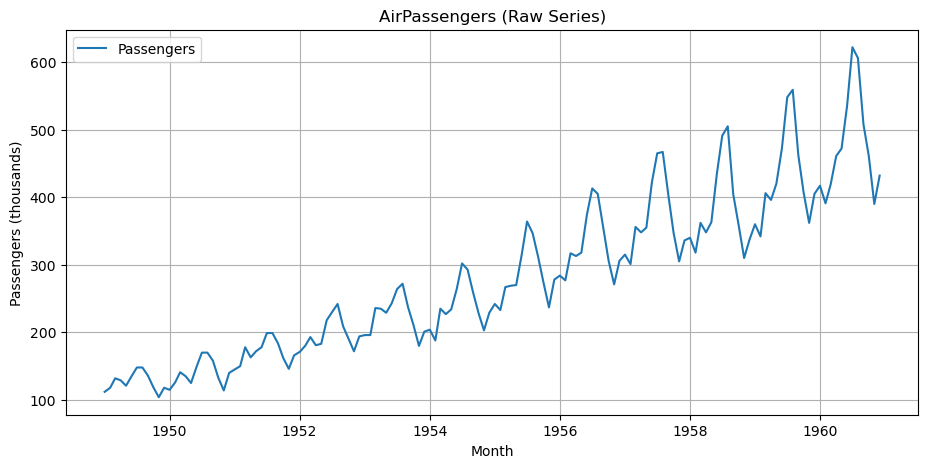

In [9]:

fig, ax = plt.subplots()
ax.plot(series.index, series.values, label='Passengers')
ax.set_title("AirPassengers (Raw Series)")
ax.set_xlabel("Month")
ax.set_ylabel("Passengers (thousands)")
ax.legend()
plt.show()


## 3. Feature Engineering and Supervised Conversion

In [11]:

def add_features_idxed(idxed: pd.Series) -> pd.DataFrame:
    d = idxed.to_frame(name='Passengers').copy()
    # Lags 1..12
    for L in range(1, 13):
        d[f'Lag_{L}'] = d['Passengers'].shift(L)
    # Rolling statistics
    d['RollMean_12'] = d['Passengers'].rolling(12).mean()
    d['RollStd_12'] = d['Passengers'].rolling(12).std()
    # Seasonal encodings
    m = d.index.month
    d['Month_Sin'] = np.sin(2*np.pi*m/12)
    d['Month_Cos'] = np.cos(2*np.pi*m/12)
    d = d.dropna()
    d['Month'] = d.index  # keep for plotting/splits
    return d.reset_index(drop=True)

feat_df = add_features_idxed(series)

# Train/Test split: Train <= 1958-12, Test = 1959-01..1960-12
split_date = pd.Timestamp('1958-12-01')
train_df = feat_df[feat_df['Month'] <= split_date].copy()
test_df  = feat_df[feat_df['Month'] >  split_date].copy()

FEATURES = [c for c in feat_df.columns if c not in ['Passengers','Month']]
X_train, y_train = train_df[FEATURES], train_df['Passengers']
X_test,  y_test  = test_df[FEATURES],  test_df['Passengers']

len(train_df), len(test_df), FEATURES[:6], '...'


(108, 24, ['Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5', 'Lag_6'], '...')

### Table 2: Pearson correlation between target and lagged values `Lag_k`.

In [13]:

rows = []
for k in range(1, 13):
    col = f'Lag_{k}'
    rows.append((k, feat_df[['Passengers', col]].corr().iloc[0,1]))
table2 = pd.DataFrame(rows, columns=['Lag','Correlation'])
table2['Correlation'] = table2['Correlation'].round(2)
table2.set_index('Lag').T


Lag,1,2,3,4,5,6,7,8,9,10,11,12
Correlation,0.95,0.88,0.82,0.78,0.77,0.77,0.77,0.78,0.82,0.88,0.95,0.99


## 4. Models: ARIMA baseline and XGBoost/RandomForest

In [15]:

# ARIMA baseline
arima_fc = None
try:
    arima_model = ARIMA(series, order=(2,1,2), seasonal_order=(1,1,1,12)).fit()
    # Forecast for test period only
    start = test_df['Month'].min()
    end   = test_df['Month'].max()
    arima_fc_series = arima_model.predict(start=start, end=end, dynamic=False)
    arima_fc = arima_fc_series.reindex(test_df['Month']).values
except Exception as e:
    print("ARIMA failed:", e)

# Gradient boosting regressor or fallback to RandomForest for portability
if HAVE_XGB:
    model = XGBRegressor(
        n_estimators=600,
        max_depth=3,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=RANDOM_STATE
    )
else:
    from sklearn.ensemble import RandomForestRegressor
    model = RandomForestRegressor(
        n_estimators=400,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )

model.fit(X_train, y_train)
ml_fc = model.predict(X_test)

# Metrics (version-safe)
rmse_ml   = rmse(y_test, ml_fc)
mape_ml   = mape_pct(y_test, ml_fc)
r2_ml     = float(r2_score(y_test, ml_fc))

rmse_arima = np.nan
mape_arima = np.nan
if arima_fc is not None:
    rmse_arima = rmse(y_test, arima_fc)
    mape_arima = mape_pct(y_test, arima_fc)

print(f"ARIMA   RMSE={rmse_arima:.2f}, MAPE={mape_arima:.2f}%")
print(f"Model({type(model).__name__}) RMSE={rmse_ml:.2f}, MAPE={mape_ml:.2f}%, R^2={r2_ml:.3f}")


ARIMA   RMSE=15.75, MAPE=2.77%
Model(XGBRegressor) RMSE=62.16, MAPE=10.71%, R^2=0.307


### Figure 1: Monthly international airline passengers with ARIMA and ML forecasts (1959–1960).

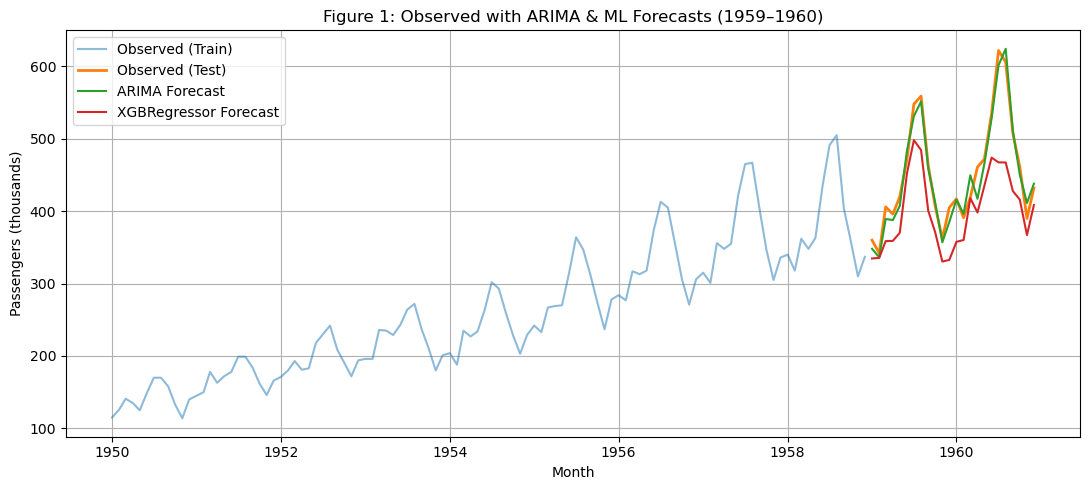

In [17]:

fig, ax = plt.subplots()
ax.plot(train_df['Month'], train_df['Passengers'], label='Observed (Train)', alpha=0.5)
ax.plot(test_df['Month'], y_test, label='Observed (Test)', linewidth=2)

if arima_fc is not None:
    ax.plot(test_df['Month'], arima_fc, label='ARIMA Forecast')

ax.plot(test_df['Month'], ml_fc, label=f'{type(model).__name__} Forecast')

ax.set_title("Figure 1: Observed with ARIMA & ML Forecasts (1959–1960)")
ax.set_xlabel("Month")
ax.set_ylabel("Passengers (thousands)")
ax.legend()
plt.tight_layout()
plt.savefig("Figure_1.png", dpi=200)
plt.show()


### Table 3: Forecast accuracy on 1959–1960 with simple block-bootstrap 95% CI.

In [19]:

def block_bootstrap_ci(y_true, y_hat, metric_fn: Callable, block=12, B=500, alpha=0.05):
    n = len(y_true)
    vals = []
    for _ in range(B):
        start = np.random.randint(0, max(1, n-block+1))
        sel = np.arange(start, min(n, start+block))
        vals.append(metric_fn(y_true[sel], y_hat[sel]))
    lo = np.percentile(vals, 100*alpha/2)
    hi = np.percentile(vals, 100*(1-alpha/2))
    return float(np.mean(vals)), (float(lo), float(hi))

# ARIMA CIs (if available)
mean_rmse_a = np.nan; ci_rmse_a = (np.nan, np.nan)
mean_mape_a = np.nan; ci_mape_a = (np.nan, np.nan)
if arima_fc is not None:
    mean_rmse_a, ci_rmse_a = block_bootstrap_ci(y_test.values, arima_fc, 
                                                lambda yt, yh: rmse(yt, yh))
    mean_mape_a, ci_mape_a = block_bootstrap_ci(y_test.values, arima_fc, 
                                                lambda yt, yh: mape_pct(yt, yh))

# ML CIs
mean_rmse_m, ci_rmse_m = block_bootstrap_ci(y_test.values, ml_fc, lambda yt, yh: rmse(yt, yh))
mean_mape_m, ci_mape_m = block_bootstrap_ci(y_test.values, ml_fc, lambda yt, yh: mape_pct(yt, yh))

table3 = pd.DataFrame({
    'Model': ['ARIMA(2,1,2)', type(model).__name__],
    'RMSE': [round(rmse_arima, 2), round(rmse_ml, 2)],
    'RMSE 95% CI': [f"[{ci_rmse_a[0]:.1f}, {ci_rmse_a[1]:.1f}]", f"[{ci_rmse_m[0]:.1f}, {ci_rmse_m[1]:.1f}]"],
    'MAPE (%)': [round(mape_arima, 2), round(mape_ml, 2)],
    'MAPE 95% CI': [f"[{ci_mape_a[0]:.1f}, {ci_mape_a[1]:.1f}]", f"[{ci_mape_m[0]:.1f}, {ci_mape_m[1]:.1f}]"]
})
table3


,Model,RMSE,RMSE 95% CI,MAPE (%),MAPE 95% CI
0,"ARIMA(2,1,2)",15.75,"[11.1, 19.8]",2.77,"[2.2, 3.4]"
1,XGBRegressor,62.16,"[47.1, 77.1]",10.71,"[9.8, 12.9]"


## 5. SHAP Global & Dependence Analyses

In [21]:

# Use TreeExplainer for tree models; KernelExplainer fallback (slow) otherwise
try:
    shap.initjs()
except Exception:
    pass

try:
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
except Exception as e:
    print("TreeExplainer failed, attempting KernelExplainer (this can be slow):", e)
    f = lambda X: model.predict(pd.DataFrame(X, columns=X_test.columns))
    explainer = shap.KernelExplainer(f, X_train.sample(min(100, len(X_train)), random_state=RANDOM_STATE))
    shap_values = explainer.shap_values(X_test, nsamples=100)

mean_abs_shap = np.abs(shap_values).mean(axis=0)
shap_ranking = pd.Series(mean_abs_shap, index=X_test.columns).sort_values(ascending=False)
shap_ranking.head(10)


Lag_12         115.047028
Lag_1           14.243304
RollMean_12     12.413747
Lag_11          10.839298
Lag_8            6.322600
Lag_7            3.197056
Month_Cos        3.172943
Lag_4            1.716374
Lag_3            1.243576
Month_Sin        0.939873
dtype: float32

### Figure 2: Global feature importance estimated via SHAP (mean |value|).

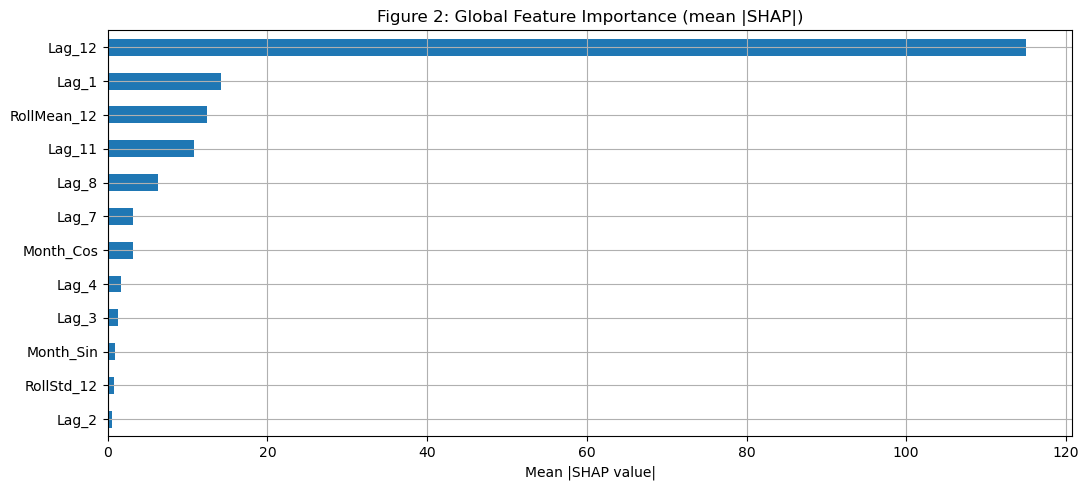

In [23]:

topn = 12
fig, ax = plt.subplots()
shap_ranking.iloc[:topn][::-1].plot(kind='barh', ax=ax)
ax.set_title("Figure 2: Global Feature Importance (mean |SHAP|)")
ax.set_xlabel("Mean |SHAP value|")
plt.tight_layout()
plt.savefig("Figure_2.png", dpi=200)
plt.show()


### Figure 3: SHAP dependence for `Lag_12` (color = `Lag_1`).

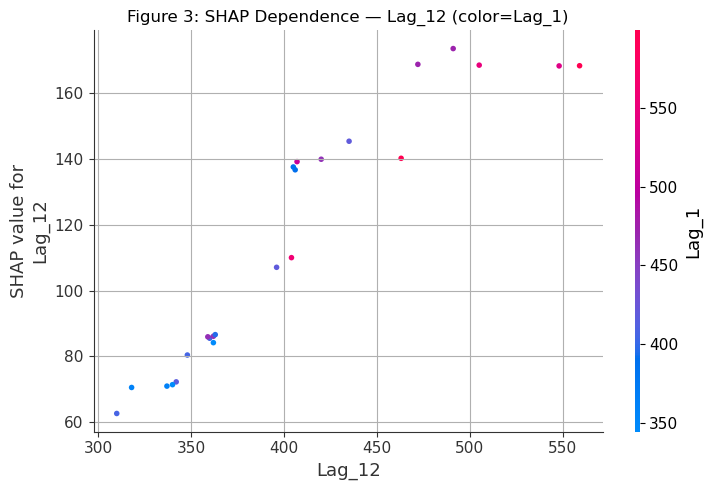

In [25]:

if 'Lag_12' in X_test.columns:
    try:
        shap.dependence_plot('Lag_12', shap_values, X_test, interaction_index='Lag_1', show=False)
        plt.title("Figure 3: SHAP Dependence — Lag_12 (color=Lag_1)")
        plt.tight_layout()
        plt.savefig("Figure_3.png", dpi=200)
        plt.show()
    except Exception as e:
        print("Dependence plot fallback:", e)
else:
    print("Lag_12 not in features; skipping Figure 3.")


## 6. LIME Local Explanation

LIME for test date: 1959-07-01 (test index 6)
Lag_12 > 286.25      -> +125.769
RollMean_12 > 321.08 -> +16.180
Lag_1 > 315.50       -> +16.025
Lag_11 > 295.00      -> +12.298
Month_Cos <= -0.59   -> +4.708
Lag_8 > 305.25       -> -3.667
Lag_9 > 302.75       -> -2.383
Lag_4 > 313.50       -> -2.305
Lag_10 > 301.25      -> -2.235
Lag_6 > 307.50       -> +2.192


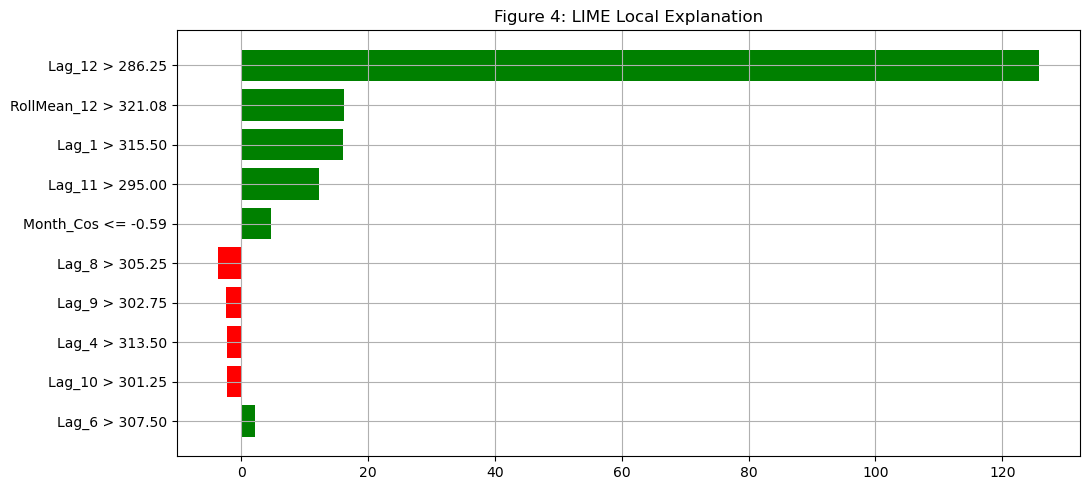

In [27]:

lime_explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=list(X_train.columns),
    mode="regression",
    verbose=False
)

target_date = pd.Timestamp('1959-07-01')
if target_date in test_df['Month'].values:
    idx = test_df.index[test_df['Month'] == target_date][0] - test_df.index[0]
else:
    idx = 0

exp = lime_explainer.explain_instance(
    data_row=X_test.iloc[idx].values,
    predict_fn=model.predict,
    num_features=min(10, X_test.shape[1])
)

print(f"LIME for test date: {test_df.iloc[idx]['Month'].date()} (test index {idx})")
for feat, val in exp.as_list():
    print(f"{feat:20s} -> {val:+.3f}")

fig = exp.as_pyplot_figure()
plt.title("Figure 4: LIME Local Explanation")
plt.tight_layout()
plt.savefig("Figure_4.png", dpi=200)
plt.show()


## 7. Permutation Feature Importance

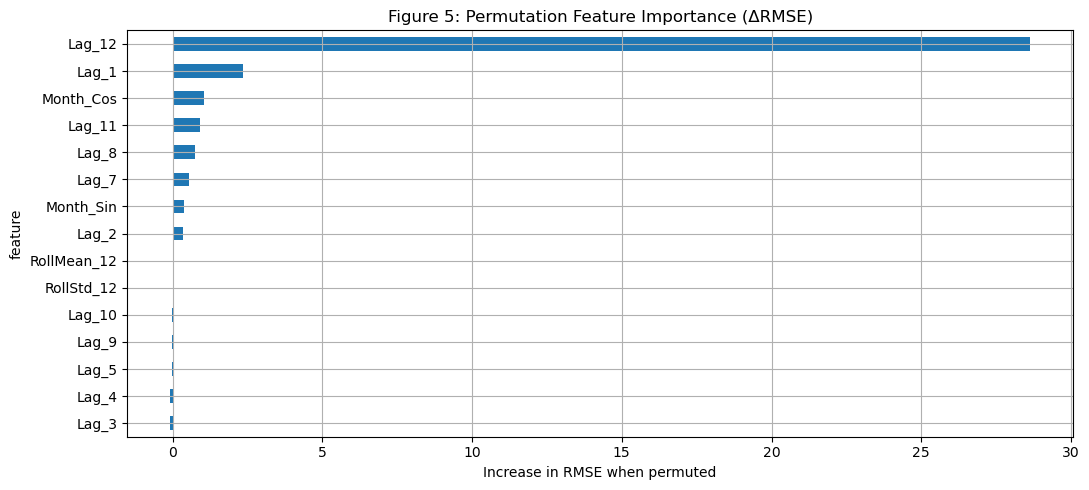

In [29]:

from sklearn.metrics import mean_squared_error

def permutation_importance_rmse(model, X: pd.DataFrame, y: pd.Series) -> pd.DataFrame:
    base = rmse(y, model.predict(X))
    rows = []
    for col in X.columns:
        Xp = X.copy()
        Xp[col] = np.random.permutation(Xp[col].values)
        rows.append({'feature': col, 'rmse_increase': rmse(y, model.predict(Xp)) - base})
    return pd.DataFrame(rows).sort_values('rmse_increase', ascending=True)

perm_imp = permutation_importance_rmse(model, X_test, y_test)
fig, ax = plt.subplots()
perm_imp.tail(15).set_index('feature')['rmse_increase'].plot(kind='barh', ax=ax)
ax.set_title("Figure 5: Permutation Feature Importance (ΔRMSE)")
ax.set_xlabel("Increase in RMSE when permuted")
plt.tight_layout()
plt.savefig("Figure_5.png", dpi=200)
plt.show()
